<a href="https://colab.research.google.com/github/wtpgbaek/skinlesion/blob/main/Untitled10_ipynb_%ED%95%B4%EC%83%81%EB%8F%84128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2
import numpy as np

from drive.MyDrive.model_layer import make_model
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras.backend as K

os.makedirs('checkpoints', exist_ok=True)

X = []
y = []

image_shape = (3, 128, 128)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
for f_label, folder_name in enumerate(('ACTINIC_KERATOSIS', 'BASAL_CELL_CARCINOMA','DERMATOFIBROMA','MELANOMA','NEVUS','PIGMENTED_BENIGN_KERATOSIS','SQUAMOUS_CELL_CARCIMONA','VASCULAR_LESION')):
    folder_path = os.path.join('/content/drive/MyDrive/jpg_section/', folder_name)
    print(folder_path)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)

        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, image_shape[1:])

        X.append(img)
        y.append(f_label)


/content/drive/MyDrive/jpg_section/ACTINIC_KERATOSIS
/content/drive/MyDrive/jpg_section/BASAL_CELL_CARCINOMA
/content/drive/MyDrive/jpg_section/DERMATOFIBROMA
/content/drive/MyDrive/jpg_section/MELANOMA
/content/drive/MyDrive/jpg_section/NEVUS
/content/drive/MyDrive/jpg_section/PIGMENTED_BENIGN_KERATOSIS
/content/drive/MyDrive/jpg_section/SQUAMOUS_CELL_CARCIMONA
/content/drive/MyDrive/jpg_section/VASCULAR_LESION


In [5]:
X = np.array(X)
y = np.array(y).reshape(-1, 1)

X = (X / 127.)
X = X.transpose(0, 3, 1, 2)
X = X.astype(np.float32)
y = y.astype(np.float32)

In [6]:
test2 = 0
level1=10
file_name=[]
def make_test_data(test1,level1):
  X=[]
  y=[]

  for f_label, folder_name in enumerate(('ACTINIC_KERATOSIS', 'BASAL_CELL_CARCINOMA','DERMATOFIBROMA','MELANOMA','NEVUS','PIGMENTED_BENIGN_KERATOSIS','SQUAMOUS_CELL_CARCIMONA','VASCULAR_LESION')):
    folder_path = os.path.join("/content/drive/MyDrive/jpg_section/", folder_name)
    print(folder_path)

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (128,128))


        X.append(img)
        y.append(f_label)

  X = np.array(X)
  y = np.array(y).reshape(-1, 1)

  X = (X / 127.)
  X = X.transpose(0, 3, 1, 2)
  X = X.astype(np.float32)
  y = y.astype(np.float32)

  x_train = X
  y_train = y
  return x_train, y_train

image_shape = (3, 128, 128)

enc = OneHotEncoder(handle_unknown='ignore')
temp_y = enc.fit_transform(y).toarray()

x_train = X
y_train = temp_y



In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(X, temp_y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [8]:
#make model
model = make_model(image_shape, num_classes=8)

epochs = 2
ckpoint= tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/jpg_section/model_save/',monitor='val_f1_score',save_best_only=True, save_weights_only=True)
earlystopping= tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=10,mode='max')

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()
spec=tf.keras.metrics.SpecificityAtSensitivity(0.5)
iou=tf.keras.metrics.MeanIoU(num_classes=8)
f1_score = tfa.metrics.F1Score(num_classes=8, threshold=0.6,average='micro')

learningrate=0.000007
opt1=tf.keras.optimizers.Adamax(learning_rate=learningrate)
opt3=tf.keras.optimizers.Adam(learning_rate=learningrate)
opt1=tf.keras.mixed_precision.LossScaleOptimizer(opt1)

losses  = 'mse'
model.compile(
        optimizer = opt1,
        loss = losses,
        metrics = [precision, recall, auc,f1_score,spec,iou]
)

In [9]:
hist=model.fit(x_train, y_train,epochs=epochs,batch_size=2,validation_data = (x_val, y_val),
        callbacks = [ckpoint]
)


Epoch 1/2
455/455 [==============================] - 46s 87ms/step - loss: 0.1051 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8200 - f1_score: 0.0000e+00 - specificity_at_sensitivity: 0.9672 - mean_io_u: 0.4375 - val_loss: 0.1067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8659 - val_f1_score: 0.0000e+00 - val_specificity_at_sensitivity: 0.9637 - val_mean_io_u: 0.4375
Epoch 2/2
455/455 [==============================] - 36s 79ms/step - loss: 0.0806 - precision: 0.7622 - recall: 0.1375 - auc: 0.8660 - f1_score: 0.1292 - specificity_at_sensitivity: 0.9731 - mean_io_u: 0.4375 - val_loss: 0.0648 - val_precision: 0.7647 - val_recall: 0.3421 - val_auc: 0.8938 - val_f1_score: 0.2714 - val_specificity_at_sensitivity: 0.9825 - val_mean_io_u: 0.4375


In [10]:
test_metrics = model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 104ms/step - loss: 0.0704 - precision: 0.7037 - recall: 0.3333 - auc: 0.8549 - f1_score: 0.2759 - specificity_at_sensitivity: 0.9737 - mean_io_u: 0.4375


In [11]:
print("Test Metrics:", test_metrics)

Test Metrics: [0.07036229968070984, 0.7037037014961243, 0.3333333432674408, 0.8549333810806274, 0.27586206793785095, 0.9736841917037964, 0.4375]


In [12]:
print(hist.history.keys())

dict_keys(['loss', 'precision', 'recall', 'auc', 'f1_score', 'specificity_at_sensitivity', 'mean_io_u', 'val_loss', 'val_precision', 'val_recall', 'val_auc', 'val_f1_score', 'val_specificity_at_sensitivity', 'val_mean_io_u'])


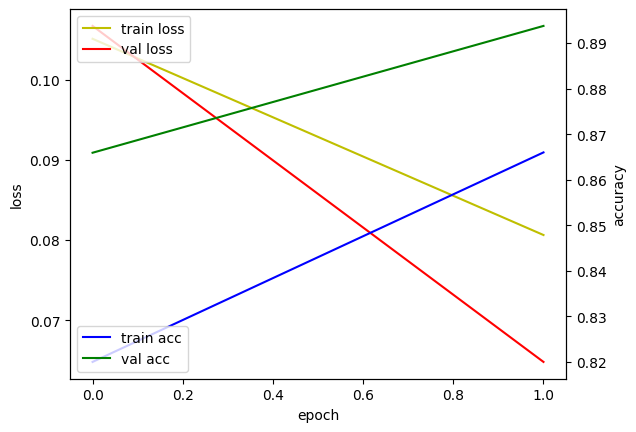

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val loss')
acc_ax.plot(hist.history['auc'],'b',label='train acc')
acc_ax.plot(hist.history['val_auc'],'g',label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [14]:
print('##### Test Result #####')
print('loss : ',str(test_metrics[0]))
print('Accuracy : ',str(test_metrics[1]))


##### Test Result #####
loss :  0.07036229968070984
Accuracy :  0.7037037014961243


In [15]:
model.save("/content/drive/MyDrive/jpg_section/model_save/classification_model_"+str(test2)+"2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
